## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 4-го спринта: "Создание рекомендательной системы"

## Этап 1. Первичная подготовка данных

### Постановка задачи

Прочитайте файлы с данными, проведите оценку данных на наличие проблем:
- Нужно ли изменить тип идентификаторов?
- Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

При необходимости решите найденные проблемы.

Сохраните предобработанные данные в удобном формате в двух файлах:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

### Описание исходных данных

Данные находятся в трёх файлах:

1. Данные о треках — в файле `tracks.parquet`:
    - `track_id` — идентификатор музыкального трека,
    - `albums` — список идентификаторов альбомов, содержащих трек,
    - `artists` — список идентификаторов исполнителей трека,
    - `genres` — список идентификаторов жанров, к которым принадлежит трек.

2. Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра),
    - `type` — тип идентификатора,
    - `name` — имя (название) каталожной единицы.

3. Данные о том, какие пользователи прослушали тот или иной трек — в файле `interactions.parquet`:
    - `user_id` — идентификатор пользователя,
    - `track_id` — идентификатор музыкального трека,
    - `track_seq` — номер места трека в истории пользователя,
    - `started_at` — дата начала прослушивания трека.

### Инициализация

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

In [3]:
import sys

# Проверяем, в каком окружении работаем
print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [2]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

### Загрузка данных

In [6]:
# Устанавливаем утилиту wget, если ее нет
!pip install wget

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for wget, since package 'wheel' is not installed.
  Running setup.py install for wget ... done


In [5]:
!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet


Saved under tracks.parquet

Saved under catalog_names.parquet

Saved under interactions.parquet


### Предобработка данных

__Загружаем и проверяем данные из файла `tracks.parquet`__

In [4]:
tracks = pd.read_parquet("tracks.parquet")
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
# Смотрим типы колонок, кол-во строк, объем данных и наличие пропусков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Пропусков нет, типы корректны, но для экономии памяти можно привести тип int64 к int32. Убедимся, что значения `track_id` не превышают максимума для int32.

In [7]:
print(f"Максимальное значение track_id: {tracks['track_id'].max()}")
print(f"Максимальное значение для int32: {2**32 - 1}")

Максимальное значение track_id: 101521819
Максимальное значение для int32: 4294967295


Таким образом, приведение к типу int32 допустимо. 

Далее проверим `track_id` на наличие дубликатов и отрицательных значений.

In [9]:
# Проверяем track_id на наличие дубликатов 
print(f"Все track_id уникальны: {tracks['track_id'].nunique() == len(tracks)}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(tracks['track_id'] < 0).sum()}")

Все track_id уникальны: True
Кол-во отрицательных track_id: 0


Повторяющихся и отрицательных track_id нет. 

В колонках `albums`, `artists` и `genres` списки идентификаторов могут быть пустыми либо содержать идентификаторы, указывающие на несуществующие каталожные единицы. Для экономии памяти оставим только те треки, у которых заполнены все четыре категории (жанр/артист/альбом/название трека).

__Загружаем и проверяем данные из файла `catalog_names.parquet`__

In [5]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
# Смотрим типы колонок, кол-во строк и объем данных
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [10]:
# Проверяем наличие пропусков
catalog_names.isnull().sum()

id      0
type    0
name    0
dtype: int64

Пропусков нет, типы колонок корректны. Сделаем еще несколько проверок.

In [11]:
# Проверяем id на наличие повторяющихся значений
print(f"Кол-во уникальных id: {catalog_names['id'].nunique()}, общее кол-во строк: {len(catalog_names)}")

# Проверяем id на наличие отрицательных значений
print(f"Кол-во отрицательных id: {(catalog_names['id'] < 0).sum()}")

# Проверяем наличие повторяющихся строк
duplicated_rows_condition = catalog_names.duplicated(catalog_names.columns, keep=False)
print(f"Кол-во повторяющихся строк: {duplicated_rows_condition.sum()}")

Кол-во уникальных id: 1776697, общее кол-во строк: 1812471
Кол-во отрицательных id: 0
Кол-во повторяющихся строк: 0


Отрицательных id и повторяющихся строк нет, но есть одинаковые идентификаторы. 
Поскольку таких значений много, то вряд ли это связано со случайными ошибками.
Скорее всего, внутри каждого типа есть своя идентификация. Убедимся в этом.

In [12]:
# Смотрим, какие есть каталожные типы
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [6]:
# Проверяем наличие повторяющихся id внутри типа album
cat_albums = catalog_names.query("type == 'album'")
print(f"Среди id альбомов нет повторяющихся значений: {cat_albums['id'].nunique() == len(cat_albums)}")

# Проверяем наличие повторяющихся id внутри типа artist
cat_artists = catalog_names.query("type == 'artist'")
print(f"Среди id артистов нет повторяющихся значений: {cat_artists['id'].nunique() == len(cat_artists)}")

# Проверяем наличие повторяющихся id внутри типа genre
cat_genres = catalog_names.query("type == 'genre'")
print(f"Среди id жанров нет повторяющихся значений: {cat_genres['id'].nunique() == len(cat_genres)}")

# Проверяем наличие повторяющихся id внутри типа track
cat_tracks = catalog_names.query("type == 'track'")
print(f"Среди id названий треков нет повторяющихся значений: {cat_tracks['id'].nunique() == len(cat_tracks)}")

Среди id альбомов нет повторяющихся значений: True
Среди id артистов нет повторяющихся значений: True
Среди id жанров нет повторяющихся значений: True
Среди id названий треков нет повторяющихся значений: True


Кол-во уникальных id внутри каждого типа равно общему кол-ву соответствующих каталожных единиц, значит повторяющихся id среди элементов одного типа действительно нет.

Далее вставим в таблицу треков названия соответствующих каталожных единиц вместо их идентификаторов.

In [7]:
# Разворачиваем tracks по каталожным ids и переименовываем колонки
tracks_exploded = tracks.explode('albums', ignore_index=True) \
    .explode('artists', ignore_index=True) \
        .explode('genres', ignore_index=True) \
            .rename(columns={'albums':'album_id', 'artists': 'artist_id', 'genres': 'genre_id'})

In [8]:
# Оставляем треки, у которых заполнены все 3 категории артист/жанр/альбом
id_columns = ['album_id', 'artist_id', 'genre_id']
tracks_exploded = tracks_exploded[~tracks_exploded[id_columns].isnull().any(axis=1)]

In [9]:
# Посмотрим, сколько осталось уникальных треков
tracks_exploded['track_id'].nunique()

980977

In [10]:
# Меняем тип object идентификаторов на int
tracks_exploded[['album_id', 'artist_id', 'genre_id']] = \
    tracks_exploded[['album_id', 'artist_id', 'genre_id']].astype('int')

In [11]:
# Вставляем в tracks_exploded имена альбомов
tracks_exploded = tracks_exploded \
    .merge(cat_albums[['id', 'name']], how='left', left_on='album_id', right_on='id') \
        .rename(columns={'name': 'album_name'}).drop(columns='id')

In [12]:
# Вставляем в tracks_exploded имена артистов
tracks_exploded = tracks_exploded \
    .merge(cat_artists[['id', 'name']], how='left', left_on='artist_id', right_on='id') \
        .rename(columns={'name': 'artist_name'}).drop(columns='id')

In [13]:
# Вставляем в tracks_exploded названия жанров
tracks_exploded = tracks_exploded\
    .merge(cat_genres[['id', 'name']], how='left', left_on='genre_id', right_on='id')\
        .rename(columns={'name': 'genre_name'}).drop(columns='id')

Сворачиваем полученный `tracks_exploded` по названиям альбомов/артистов/жанров и добавляем названия треков.

In [14]:
# Удаляем колонки с id каталогов
tracks_exploded.drop(columns=['artist_id', 'genre_id', 'album_id'], inplace=True)

In [15]:
# Сворачиваем названия каталогов в списки
tracks = tracks_exploded.groupby('track_id') \
    .agg({'album_name': lambda x: x.tolist(), 'artist_name': lambda x: x.tolist(), 'genre_name': lambda x: x.tolist()}) \
        .rename({'album_name': 'albums', 'artist_name': 'artists', 'genre_name': 'genres'}, axis=1) \
            .reset_index()

In [16]:
# Удаляем повторяющиеся названия в списках каталогов
tracks['albums'] = tracks['albums'].apply(lambda x: list(set(x)))
tracks['artists'] = tracks['artists'].apply(lambda x: list(set(x)))
tracks['genres'] = tracks['genres'].apply(lambda x: list(set(x)))

In [17]:
# Вставляем названия треков
tracks = tracks \
    .merge(cat_tracks[['id', 'name']], how='left', left_on='track_id', right_on='id') \
        .drop(columns='id')

Проверим, есть ли треки без названий.

In [18]:
print(f"Кол-во треков без названий: {tracks['name'].isnull().sum()}")

Кол-во треков без названий: 0


In [19]:
# Смотрим, что получилось
tracks.head()

,track_id,albums,artists,genres,name
0,26,[Taller Children],[Elizabeth & the Catapult],"[pop, folk]",Complimentary Me
1,38,[Taller Children],[Elizabeth & the Catapult],"[pop, folk]",Momma's Boy
2,135,[Wild Young Hearts],[Noisettes],[pop],Atticus
3,136,[Wild Young Hearts],[Noisettes],[pop],24 Hours
4,138,"[Clubland Classix, Don't Upset The Rhythm, I A...",[Noisettes],[pop],Don't Upset The Rhythm (Go Baby Go)


__Загружаем и проверяем данные из файла `interactions.parquet`__

In [20]:
interactions = pd.read_parquet("interactions.parquet")
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [48]:
# Смотрим типы колонок, кол-во строк и объем данных
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [49]:
# Проверяем наличие пропусков
interactions.isnull().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Пропусков нет, тип int32 у `user_id` и `track_id` оставим как есть для экономии памяти. Сделаем такой же тип в `tracks`, т.к. ранее мы уже проверили, что это допустимо.

In [21]:
# Приводим track_id к int32
tracks['track_id'] = tracks['track_id'].astype('int32')

Далее проверим корректность значений `user_id`, `track_id` и `track_seq`.

In [51]:
# Проверяем user_id на наличие отрицательных значений
print(f"Кол-во отрицательных user_id: {(interactions['user_id'] < 0).sum()}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(interactions['track_id'] < 0).sum()}")

# Проверяем track_seq на наличие отрицательных и нулевых значений 
# (track_seq не могут быть нулевыми по смыслу)
print(f"Кол-во неположительных track_seq: {(interactions['track_seq'] <= 0).sum()}")

Кол-во отрицательных user_id: 0
Кол-во отрицательных track_id: 0
Кол-во неположительных track_seq: 0


Оставим в `interactions` только те треки, которые есть в `tracks`.

In [22]:
# Удаляем из истории взаимодействий лишние треки
interactions = interactions[interactions['track_id'].isin(tracks['track_id'])]

# Смотрим, сколько осталось строк после удаления
len(interactions)

222184449

Взаимодействий все еще очень много. Оставим только пользователей, прослушавших 1000 треков и более.

In [44]:
# Оставляем только самых активных пользователей для экономии ресурсов
agg_users = interactions.groupby("user_id").agg(tracks=("started_at", "count"))
filtered_users = agg_users[agg_users['tracks'] >= 1000]
interactions = interactions[interactions['user_id'].isin(filtered_users.index)]

In [46]:
# Посмотрим кол-во строк и объем памяти
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60389686 entries, 0 to 1410
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 1.5 GB


Проверим, есть ли в `interactions` повторяющиеся пары идентификаторов (`user_id`, `track_id`).

In [50]:
duplicated_rows_condition = interactions.duplicated(['user_id', 'track_id'], keep=False)
print(f"Кол-во повторяющихся пар (user, item): {duplicated_rows_condition.sum()}")

Кол-во повторяющихся пар (user, item): 0


В конце переименуем таблицы `tracks`, `interactions`, а также их колонки `track_id` и `track_seq`, после чего сохраним полученные таблицы на диск.

In [51]:
# Переименовываем колонки
tracks.rename(columns={'track_id': 'item_id'}, inplace=True)
interactions.rename(columns={'track_id': 'item_id', 'track_seq': 'item_seq'}, inplace=True)

In [52]:
# Переименовываем таблицы
items = tracks
events = interactions

# Удаляем из памяти уже ненужную таблицу
del catalog_names

In [53]:
# Сохраняем в файлы
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

Удаляем исходные файлы.

In [41]:
file_name = "tracks.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

file_name = "catalog_names.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

file_name = "interactions.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

File tracks.parquet removed successfully
File catalog_names.parquet removed successfully
File interactions.parquet removed successfully


## Этап 2. Анализ данных (EDA)

### Постановка задачи

Проведите EDA данных, чтобы получить представление о следущих параметрах:
- распределение количества прослушанных треков,
- наиболее популярные треки,
- наиболее популярные жанры,
- треки, которые никто не прослушал.

In [5]:
# Загружаем данные из файлов
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Посмотрим распределение кол-ва прослушиваний треков и уникальных пользователей по месяцам.

In [54]:
from pandas.tseries.offsets import MonthEnd

# Добавляем колонку с начальными датами для каждого месяца
events["started_at_month"] = events["started_at"].dt.to_period('M').dt.to_timestamp().dt.date

In [7]:
# Группируем события по месяцам
events_by_month = events.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

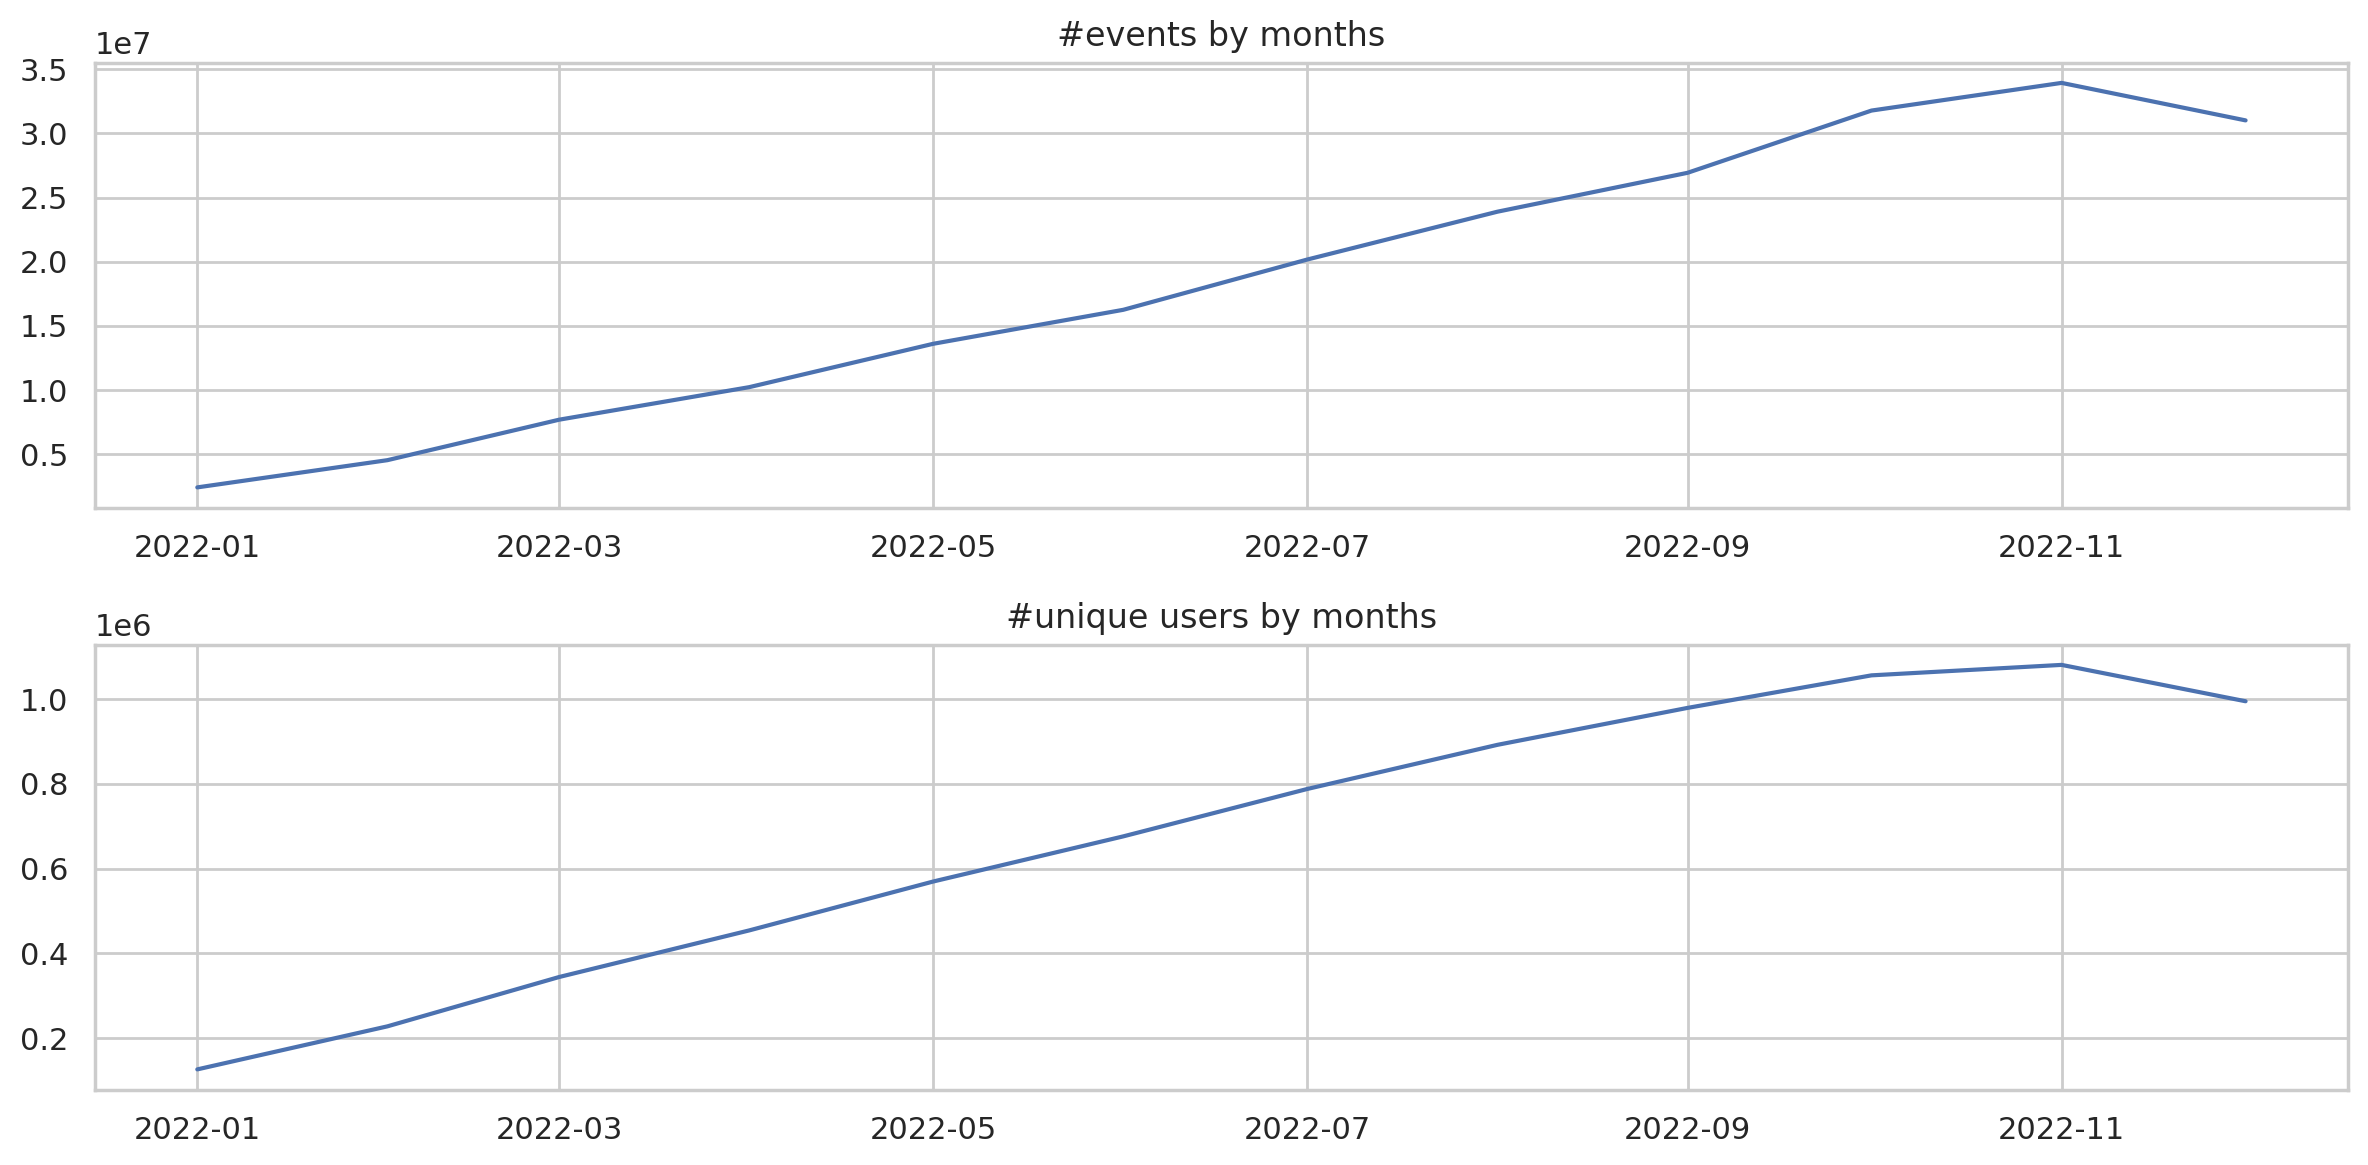

In [8]:
# Визуализируем распределение кол-ва взаимодействий и уникальных пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_by_month["started_at_month"], events_by_month["events"])
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_by_month["started_at_month"], events_by_month["users"])
ax.set_title("#unique users by months")

fig.tight_layout()

Видим, что история взаимодействий охватывает только 2022 г. Кол-во прослушиваний и уникальных пользователей постепенно росло вплоть до ноября, после чего начало немного снижаться. Возможно, сервис был запущен в самом начале 2022 г., пик его популярности пришелся на конец года и затем начал спадать. Такое изменение в распределении данных может привести к низким оценкам качества рекомендаций при их валидации.

Найдем топ-100 наиболее популярных треков по общему кол-ву прослушиваний.

In [55]:
pop_items = events \
    .groupby(["item_id"]).agg(plays=("started_at", "count"), users=("user_id", "nunique")).reset_index()

# Сортируем по убыванию кол-ва прослушиваний, а при их равенстве - по убыванию уникальных пользователей
pop_items = pop_items.sort_values(['plays', 'users'], ascending=[False, False])

# Выбираем первые 100 самых прослушиваемых треков 
top_k_pop_items = pop_items[:100].reset_index().drop(columns='index')

In [56]:
# Добавляем колонки с названиями всех каталожных единиц
top_k_pop_items = top_k_pop_items \
    .merge(items[['item_id', 'name', 'genres', 'artists', 'albums']], how='inner', on='item_id')
top_k_pop_items.head()

,item_id,plays,users,name,genres,artists,albums
0,53404,15704,15704,Smells Like Teen Spirit,"[allrock, alternative, rock]",[Nirvana],"[Skiing Music, Smells Like Teen Spirit / In Bl..."
1,178529,14088,14088,Numb,"[metal, numetal]",[Linkin Park],"[00s Rock Anthems, Meteora]"
2,37384,12798,12798,Zombie,"[allrock, rock]",[The Cranberries],"[Halloween Pop, Halloween Party da paura, Clas..."
3,6705392,12735,12735,Seven Nation Army,[alternative],[The White Stripes],"[PAY CLOSE ATTENTION: XL Recordings, Elephant,..."
4,33311009,11972,11972,Believer,"[allrock, rock]",[Imagine Dragons],"[Shape Of Pop, Study Songs, Rock Playlist, 202..."


Сохраняем эти данные в файл `top_popular.parquet` для последующего использования в качестве готовых рекомендаций по умолчанию.

In [57]:
top_k_pop_items.to_parquet('top_popular.parquet')

Определим самые популярные жанры. Для этого пройдемся по только что отобранным топ-трекам и посчитаем, к каким жанрам они относятся. Жанры с наибольшей встречаемостью будут самыми популярными.

In [58]:
# Функция для извлечения жанров из треков
def get_genres(items):

    """ 
    Извлекает жанры из треков и считает, сколько раз встречается каждый жанр.
    """    
    genres_counter = {}
    
    for k, v in items.iterrows():
        if v["genres"] is None: # После предобработки NA быть не может, оставили для общего случая
            continue
        
        genres = list(v["genres"])

        for genre in genres:
            try:
                genres_counter[genre] += 1 
            except KeyError:
                genres_counter[genre] = 1

    genres = pd.Series(genres_counter, name="items_count")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"

    return genres

In [59]:
# Извлекаем жанры из самых популярных треков и считаем score для каждого жанра, как долю от общего кол-ва треков
top_k_pop_items_genres = get_genres(top_k_pop_items)
top_k_pop_items_genres["score"] = top_k_pop_items_genres["items_count"] / top_k_pop_items_genres["items_count"].sum()

Text(0.5, 1.0, 'Top 10 most played genres')

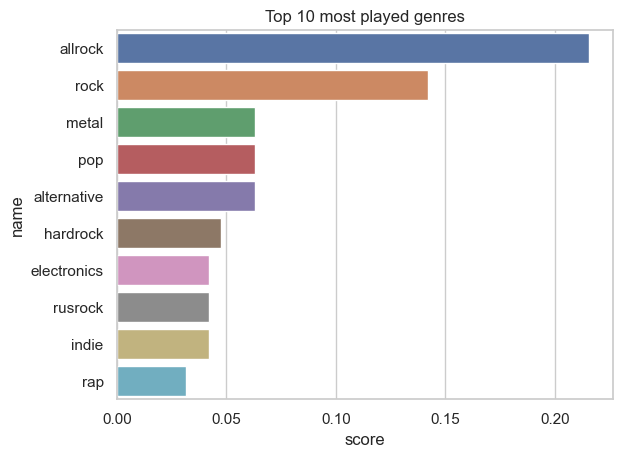

In [60]:
# Строим горизонтальный barplot
sns.barplot(data=top_k_pop_items_genres.sort_values(by="score", ascending=False).head(10), x='score', y='name').set_title("Top 10 most played genres")

Таким образом, в топ-100 самых прослушиваемых треков среди самых активных пользователей наиболее распространенным жанром является allrock.

Также подготовим список жанров по всем трекам. Он понадобится для построения контентных рекомендаций.

In [61]:
# Извлекаем жанры по всем трекам
genres = get_genres(items)
genres["score"] = genres["items_count"] / genres["items_count"].sum()

In [62]:
# Смотрим отсортированный список жанров
genres.sort_values(by="score", ascending=False)

,name,items_count,score
genre_id,,,
0,pop,166284,0.103221
20,rap,128212,0.079588
2,allrock,118506,0.073563
11,electronics,114232,0.070910
6,metal,72311,0.044887
...,...,...,...
127,business,7,0.000004
135,technologies,4,0.000002
128,religion,4,0.000002


Всего у нас получилось 143 разных жанра, чаще всего встречается pop.

In [63]:
# Сохраняем жанры в файл
genres.to_parquet('genres.parquet')

Проверим кол-во непрослушанных треков, т.е. таких, которые есть в `items`, но нет в `events`.

In [64]:
# Уникальные id всех треков
all_items_ids = set(items['item_id'])
        
# Уникальные id только прослушанных треков
played_items_ids = set(events['item_id'].unique()) 

# Треки, которые есть в items, но нет в events
not_played_items_ids = list(all_items_ids - played_items_ids)
print(f"Кол-во непрослушанных треков: {len(not_played_items_ids)}")

Кол-во непрослушанных треков: 32271


После удаления лишних записей в истории взаимодействий появилось много непрослушанных треков.
Не будем их удалять, т.к. по ним все равно можно строить контентные рекомендации. 